# TODO:

        go back to pipelines......

        1) BERT transfer learning
        1b) WHy SVC so much faster than Logistic?
        1c) what about removing neutral??
        2) train unique RNN? ehhhhh
        3) which countries most accurate in?
        4) what words are appearing in mislabeled tweets?
        5) further location cleaning / explanations for tfidf and count (and f1/precision/recall)

     |████████████████████████████████| 71kB 4.9MB/s 


In [4]:
import numpy as np 
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
import re 
import string
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score, classification_report
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from wordcloud import WordCloud
import chart_studio.plotly as py
import plotly.graph_objects as go
from plotly.offline import download_plotlyjs, plot, iplot

from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import TweetTokenizer

from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import os
from os import path

In [5]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [6]:
import nltk
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


True

In [8]:
# train, test, rona4, pipe_results
from google.colab import files
file = files.upload()

Saving Corona_NLP_test.csv to Corona_NLP_test.csv
Saving Corona_NLP_train.csv to Corona_NLP_train.csv


In [9]:
# Load in training data
train = pd.read_csv('Corona_NLP_train.csv', encoding = 'latin1')
# Copy training data
df = train.copy()
df.head()

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
0,3799,48751,London,16-03-2020,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,Neutral
1,3800,48752,UK,16-03-2020,advice Talk to your neighbours family to excha...,Positive
2,3801,48753,Vagabonds,16-03-2020,Coronavirus Australia: Woolworths to give elde...,Positive
3,3802,48754,NaN,16-03-2020,My food stock is not the only one which is emp...,Positive
4,3803,48755,NaN,16-03-2020,"Me, ready to go at supermarket during the #COV...",Extremely Negative


In [10]:
# Load in test data
test_df = pd.read_csv('Corona_NLP_test.csv', encoding = 'latin1')
test_df.head()

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
0,1,44953,NYC,02-03-2020,TRENDING: New Yorkers encounter empty supermar...,Extremely Negative
1,2,44954,"Seattle, WA",02-03-2020,When I couldn't find hand sanitizer at Fred Me...,Positive
2,3,44955,NaN,02-03-2020,Find out how you can protect yourself and love...,Extremely Positive
3,4,44956,Chicagoland,02-03-2020,#Panic buying hits #NewYork City as anxious sh...,Negative
4,5,44957,"Melbourne, Victoria",03-03-2020,#toiletpaper #dunnypaper #coronavirus #coronav...,Neutral


## 2) Data Cleaning


In [11]:
# Check for nulls
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41157 entries, 0 to 41156
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   UserName       41157 non-null  int64 
 1   ScreenName     41157 non-null  int64 
 2   Location       32567 non-null  object
 3   TweetAt        41157 non-null  object
 4   OriginalTweet  41157 non-null  object
 5   Sentiment      41157 non-null  object
dtypes: int64(2), object(4)
memory usage: 1.9+ MB


In [12]:
# Replace na with 'None'
df['Location'].fillna('None', inplace = True)
df.head()

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
0,3799,48751,London,16-03-2020,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,Neutral
1,3800,48752,UK,16-03-2020,advice Talk to your neighbours family to excha...,Positive
2,3801,48753,Vagabonds,16-03-2020,Coronavirus Australia: Woolworths to give elde...,Positive
3,3802,48754,None,16-03-2020,My food stock is not the only one which is emp...,Positive
4,3803,48755,None,16-03-2020,"Me, ready to go at supermarket during the #COV...",Extremely Negative


In [13]:
# Join stopwords together and set them for use in cleaning function.
", ".join(stopwords.words('english'))
stops = set(stopwords.words('english'))

# Function that cleans tweets for classification. 
def clean_tweet(tweet):
    # Remove hyperlinks.
    tweet= re.sub(r'https?://\S+|www\.\S+','',tweet)
    # Remove html
    tweet = re.sub(r'<.*?>','',tweet)
    # Remove numbers (Do we want to remove numbers? Death toll?)
    tweet = re.sub(r'\d+','',tweet)
    # Remove mentions
    tweet = re.sub(r'@\w+','',tweet)
    # Remove punctuation
    tweet = re.sub(r'[^\w\s\d]','',tweet)
    # Remove whitespace
    tweet = re.sub(r'\s+',' ',tweet).strip()
    # Remove stopwords
    tweet = " ".join([word for word in str(tweet).split() if word not in stops])
    
    return tweet.lower()

In [14]:
# Check function
example2 = df['OriginalTweet'][1]
clean_tweet(example2)

'advice talk neighbours family exchange phone numbers create contact list phone numbers neighbours schools employer chemist gp set online shopping accounts poss adequate supplies regular meds order'

In [15]:
# Apply text cleaning function to training and test dataframes.
df['newTweet'] = df['OriginalTweet'].apply(lambda x: clean_tweet(x))
test_df['newTweet'] = test_df['OriginalTweet'].apply(lambda x: clean_tweet(x))
df.head()

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment,newTweet
0,3799,48751,London,16-03-2020,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,Neutral,
1,3800,48752,UK,16-03-2020,advice Talk to your neighbours family to excha...,Positive,advice talk neighbours family exchange phone n...
2,3801,48753,Vagabonds,16-03-2020,Coronavirus Australia: Woolworths to give elde...,Positive,coronavirus australia woolworths give elderly ...
3,3802,48754,None,16-03-2020,My food stock is not the only one which is emp...,Positive,my food stock one empty please dont panic ther...
4,3803,48755,None,16-03-2020,"Me, ready to go at supermarket during the #COV...",Extremely Negative,me ready go supermarket covid outbreak not im ...


In [16]:
def token_stem(tweet):
    tk = TweetTokenizer()
    stemmer = PorterStemmer()
    tweet = tk.tokenize(tweet)
    tweet = [stemmer.stem(word) for word in tweet]
    tweet =  tweet = " ".join([word for word in tweet])
    return tweet

In [17]:
def token_lemma(tweet):
    tk = TweetTokenizer()
    lemma = WordNetLemmatizer()
    tweet = tk.tokenize(tweet)
    tweet = [lemma.lemmatize(word) for word in tweet]
    tweet = " ".join([word for word in tweet])
    return tweet

In [18]:
tweet = df['newTweet'][1]
tweet

'advice talk neighbours family exchange phone numbers create contact list phone numbers neighbours schools employer chemist gp set online shopping accounts poss adequate supplies regular meds order'

In [19]:
print(token_stem(tweet))
print('\n')
print(token_lemma(tweet))

advic talk neighbour famili exchang phone number creat contact list phone number neighbour school employ chemist gp set onlin shop account poss adequ suppli regular med order


advice talk neighbour family exchange phone number create contact list phone number neighbour school employer chemist gp set online shopping account po adequate supply regular med order


In [20]:
df['stemTweet'] = df['newTweet'].apply(lambda x: token_stem(x))
df['lemmaTweet'] = df['newTweet'].apply(lambda x: token_lemma(x))
df.head()

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment,newTweet,stemTweet,lemmaTweet
0,3799,48751,London,16-03-2020,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,Neutral,,,
1,3800,48752,UK,16-03-2020,advice Talk to your neighbours family to excha...,Positive,advice talk neighbours family exchange phone n...,advic talk neighbour famili exchang phone numb...,advice talk neighbour family exchange phone nu...
2,3801,48753,Vagabonds,16-03-2020,Coronavirus Australia: Woolworths to give elde...,Positive,coronavirus australia woolworths give elderly ...,coronaviru australia woolworth give elderli di...,coronavirus australia woolworth give elderly d...
3,3802,48754,None,16-03-2020,My food stock is not the only one which is emp...,Positive,my food stock one empty please dont panic ther...,my food stock one empti pleas dont panic there...,my food stock one empty please dont panic ther...
4,3803,48755,None,16-03-2020,"Me, ready to go at supermarket during the #COV...",Extremely Negative,me ready go supermarket covid outbreak not im ...,me readi go supermarket covid outbreak not im ...,me ready go supermarket covid outbreak not im ...


In [21]:
# Create more useful labels for classification.
# We will take the original 5 possibilites and
# reduce them to 3, removing the "extremelys".
def make_label(sentiment):
    
    label = ''
    if 'Positive' in sentiment: 
        label = 1
    if 'Negative' in sentiment:
        label = -1
    if 'Neutral' in sentiment:
        label = 0
    return label

In [22]:
# Apply make_label funtion to training and test dataframes.
df['label'] = df['Sentiment'].apply(lambda x: make_label(x))
test_df['label'] = test_df['Sentiment'].apply(lambda x: make_label(x))
df.head()

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment,newTweet,stemTweet,lemmaTweet,label
0,3799,48751,London,16-03-2020,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,Neutral,,,,0
1,3800,48752,UK,16-03-2020,advice Talk to your neighbours family to excha...,Positive,advice talk neighbours family exchange phone n...,advic talk neighbour famili exchang phone numb...,advice talk neighbour family exchange phone nu...,1
2,3801,48753,Vagabonds,16-03-2020,Coronavirus Australia: Woolworths to give elde...,Positive,coronavirus australia woolworths give elderly ...,coronaviru australia woolworth give elderli di...,coronavirus australia woolworth give elderly d...,1
3,3802,48754,None,16-03-2020,My food stock is not the only one which is emp...,Positive,my food stock one empty please dont panic ther...,my food stock one empti pleas dont panic there...,my food stock one empty please dont panic ther...,1
4,3803,48755,None,16-03-2020,"Me, ready to go at supermarket during the #COV...",Extremely Negative,me ready go supermarket covid outbreak not im ...,me readi go supermarket covid outbreak not im ...,me ready go supermarket covid outbreak not im ...,-1


In [23]:
# Some frequent US locations
us_filters = ('New York', 'New York, NY', 'NYC', 'NY', 'Washington, DC', 'Los Angeles, CA',
             'Seattle, Washington', 'Chicago', 'Chicago, IL', 'California, USA', 'Atlanta, GA',
             'San Francisco, CA', 'Boston, MA', 'New York, USA', 'Texas, USA', 'Austin, TX',
              'Houston, TX', 'New York City', 'Philadelphia, PA', 'Florida, USA', 'Seattle, WA',
             'Washington, D.C.', 'San Diego, CA', 'Las Vegas, NV', 'Dallas, TX', 'Denver, CO',
             'New Jersey, USA', 'Brooklyn, NY', 'California', 'Michigan, USA', 'Minneapolis, MN',
             'Virginia, USA', 'Miami, FL', 'Texas', 'Los Angeles', 'United States', 'San Francisco',
             'Indianapolis, IN', 'Pennsylvania, USA', 'Phoenix, AZ', 'New Jersey', 'Baltimore, MD',
             'CA', 'FL', 'DC', 'TX', 'IL', 'MA', 'PA', 'GA', 'NC', 'NJ', 'WA', 'VA', 'PAK', 'MI', 'OH',
             'CO', 'AZ', 'D.C.', 'WI', 'MD', 'MO', 'TN', 'Florida', 'IN', 'NV', 'MN', 'OR','LA', 'Michigan',
             'CT', 'SC', 'OK', 'Illinois', 'Ohio', 'UT', 'KY', 'Arizona', 'Colorado')

# Various nation's frequent locations
uk_filters = ('England', 'London', 'london', 'United Kingdom', 'united kingdom',
              'England, United Kingdom', 'London, UK', 'London, England',
              'Manchester, England', 'Scotland, UK', 'Scotland', 'Scotland, United Kingdom',
              'Birmingham, England', 'UK', 'Wales')
india_filters = ('New Delhi, India', 'Mumbai', 'Mumbai, India', 'New Delhi', 'India', 
                 'Bengaluru, India')
australia_filters = ('Sydney, Australia', 'New South Wales', 'Melbourne, Australia', 'Sydney',
                     'Sydney, New South Wales', 'Melbourne, Victoria', 'Melbourne', 'Australia')
canada_filters = ('Toronto, Ontario', 'Toronto', 'Ontario, Canada', 'Toronto, Canada', 'Canada',
                  'Vancouver, British Columbia', 'Ontario', 'Victoria', 'British Columbia', 'Alberta',)
south_africa_filters = ('Johannesburg, South Africa', 'Cape Town, South Africa', 'South Africa')
nigeria_filters = ('Lagos, Nigeria')
kenya_filters = ('Nairobi, Kenya')
france_filters = ('Paris, France')
ireland_filters = ('Ireland')
new_zealand_filters = ('New Zealand')
pakistan_filters = ('Pakistan')
malaysia_filters = ('Malaysia')
uganda_filters = ('Kampala, Uganda', 'Uganda')
singapore_filters = ('Singapore')
germany_filters = ('Germany', 'Deutschland')
switz_filters = ('Switzerland')
uae_filters = ('United Arab Emirates', 'Dubai')
spain_filters = ('Spain')
belg_filters = ('Belgium')
phil_filters = ('Philippines')
hk_filters = ('Hong Kong')
ghana_filters = ('Ghana')
# These all have large counts. Need to be removed from rest of data
other_filters = ('None', 'Worldwide', 'Global', 'Earth', '??')

In [24]:
df['country'] = df['Location'].apply(lambda x: x.split(",")[-1].strip() if ("," in x) else x)

In [25]:
df.head()

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment,newTweet,stemTweet,lemmaTweet,label,country
0,3799,48751,London,16-03-2020,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,Neutral,,,,0,London
1,3800,48752,UK,16-03-2020,advice Talk to your neighbours family to excha...,Positive,advice talk neighbours family exchange phone n...,advic talk neighbour famili exchang phone numb...,advice talk neighbour family exchange phone nu...,1,UK
2,3801,48753,Vagabonds,16-03-2020,Coronavirus Australia: Woolworths to give elde...,Positive,coronavirus australia woolworths give elderly ...,coronaviru australia woolworth give elderli di...,coronavirus australia woolworth give elderly d...,1,Vagabonds
3,3802,48754,None,16-03-2020,My food stock is not the only one which is emp...,Positive,my food stock one empty please dont panic ther...,my food stock one empti pleas dont panic there...,my food stock one empty please dont panic ther...,1,None
4,3803,48755,None,16-03-2020,"Me, ready to go at supermarket during the #COV...",Extremely Negative,me ready go supermarket covid outbreak not im ...,me readi go supermarket covid outbreak not im ...,me ready go supermarket covid outbreak not im ...,-1,None


In [26]:
# Changing strings found with filters into 3 digit codes
df['country'] = df['country'].apply(lambda x: 'USA' if x in us_filters else x)
df['country'] = df['country'].apply(lambda x: 'GBR' if x in uk_filters else x)
df['country'] = df['country'].apply(lambda x: 'IND' if x in india_filters else x)
df['country'] = df['country'].apply(lambda x: 'AUS' if x in australia_filters else x)
df['country'] = df['country'].apply(lambda x: 'CAN' if x in canada_filters else x)
df['country'] = df['country'].apply(lambda x: 'ZAF' if x in south_africa_filters else x)
df['country'] = df['country'].apply(lambda x: 'KEN' if x in kenya_filters else x)
df['country'] = df['country'].apply(lambda x: 'NGA' if x in nigeria_filters else x)
df['country'] = df['country'].apply(lambda x: 'SGP' if x in singapore_filters else x)
df['country'] = df['country'].apply(lambda x: 'FRA' if x in france_filters else x)
df['country'] = df['country'].apply(lambda x: 'NZL' if x in new_zealand_filters else x)
df['country'] = df['country'].apply(lambda x: 'PAK' if x in pakistan_filters else x)
df['country'] = df['country'].apply(lambda x: 'MYS' if x in malaysia_filters else x)
df['country'] = df['country'].apply(lambda x: 'IRL' if x in ireland_filters else x)
df['country'] = df['country'].apply(lambda x: 'UGA' if x in uganda_filters else x)
df['country'] = df['country'].apply(lambda x: 'DEU' if x in germany_filters else x)
df['country'] = df['country'].apply(lambda x: 'CHE' if x in switz_filters else x)
df['country'] = df['country'].apply(lambda x: 'ARE' if x in uae_filters else x)
df['country'] = df['country'].apply(lambda x: 'ESP' if x in spain_filters else x)
df['country'] = df['country'].apply(lambda x: 'BEL' if x in belg_filters else x)
df['country'] = df['country'].apply(lambda x: 'PHL' if x in phil_filters else x)
df['country'] = df['country'].apply(lambda x: 'GHA' if x in ghana_filters else x)
df['country'] = df['country'].apply(lambda x: 'HKG' if x in hk_filters else x)
df['country'] = df['country'].apply(lambda x: 'None' if x in other_filters else x)

In [27]:
df['country'].value_counts()

USA                               9675
None                              8980
GBR                               3811
CAN                               1233
IND                               1097
                                  ... 
North Pole ?                         1
Double parked n twilight zone!       1
Western Bay of Plenty District       1
Lewes                                1
Nigeria ?? Ghana ??                  1
Name: country, Length: 7313, dtype: int64

In [28]:
# 0:24 because that's where the labeled countries end
places_df = pd.DataFrame(df['country'].value_counts()[0:30])
places_df.reset_index(inplace = True)
places_df.rename(columns = {'index':'Country', 'country':'Tweets'}, inplace = True)
# Remove 'None' location
places_df = places_df[places_df['Country'] != 'None']

In [29]:
data = dict(type='choropleth',
            colorscale = 'inferno',
            locations = places_df['Country'],
            z = places_df['Tweets'],
            #locationmode = 'USA-states',
            text = places_df['Tweets'],
            marker = dict(line = dict(color = 'rgb(255,255,255)',width = 2)),
            colorbar = {'title':"Number of Tweets"}
            ) 

layout = dict(title = 'Number of Tweets By Country',
              geo = dict(#scope='usa',
                         showlakes = False,
                         lakecolor = 'rgb(85,173,240)',
                         projection_type='equirectangular')
             )

choromap = go.Figure(data = [data],layout = layout)

In [30]:
iplot(choromap)

In [31]:
# image courtesy of https://tse2.mm.bing.net/th?id=OIP.VLv_PpEOc8TDwuTNvj5hWQHaHa&pid=Api
mask = np.array(Image.open("rona4.jpeg"))

# Positive WordCloud
pos_df = df[df['label'] == 1]
pos_text = pos_df['newTweet'].to_string(index = False)
pos_text = re.sub(r'\n','',pos_text)
pos_cloud = WordCloud(colormap = 'Greens', mask = mask).generate(pos_text)

# Neutral WordCloud
neut_df = df[df['label'] == 0]
neut_text = neut_df['newTweet'].to_string(index = False)
neut_text = re.sub(r'\n','', neut_text)
neut_cloud = WordCloud(colormap = 'Blues', mask = mask).generate(neut_text)

# Negative wordcloud
neg_df = df[df['label'] == -1]
neg_text = neg_df['newTweet'].to_string(index = False)
neg_text = re.sub(r'\n','', neg_text)
neg_cloud = WordCloud(colormap = 'Reds', mask = mask).generate(neg_text)

FileNotFoundError: ignored

NameError: ignored

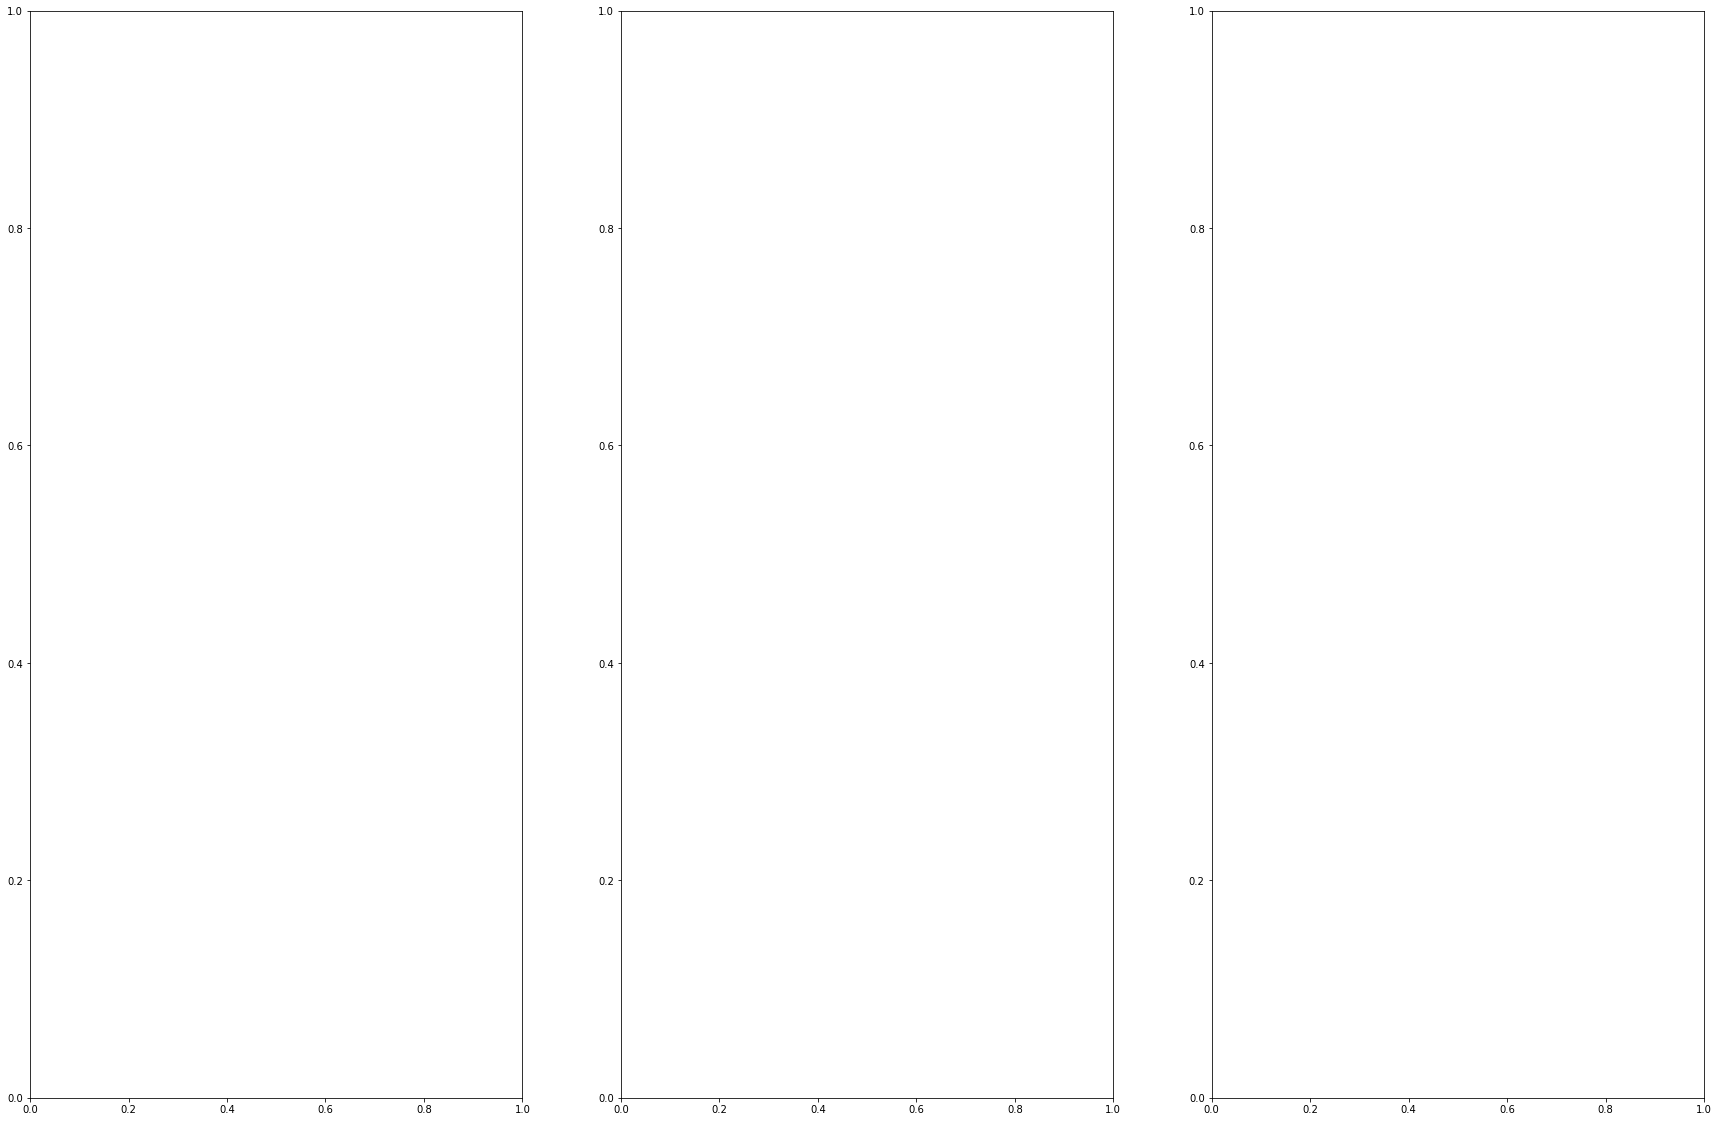

In [33]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize = [30,20])
ax1.imshow(pos_cloud)
ax1.set_title('Positive Cloud', fontsize = 30)
ax1.axis('off')
ax2.imshow(neut_cloud)
ax2.set_title('Neutral Cloud', fontsize = 30)
ax2.axis('off')
ax3.imshow(neg_cloud)
ax3.set_title('Negative Cloud', fontsize = 30)
ax3.axis('off')

Tried to use an image of the coronavirus for the mask, it certainly could have turned out better...
'Grocery store', 'price', 'supermarket', and 'online shopping' being frequent in positive, neutral, and negative tweets is interesting.  Some stand-out negative terms are 'panic buying' and 'toilet paper'. For positive, 'hand sanitizer' catches my attention. 

In [32]:
def ngram_df(corpus,nrange,n=None):
    vec = CountVectorizer(stop_words = 'english',ngram_range=nrange).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    total_list=words_freq[:n]
    df=pd.DataFrame(total_list,columns=['text','count'])
    return df

In [33]:
unigram_df = ngram_df(df['newTweet'],(1,1),20)
bigram_df = ngram_df(df['newTweet'],(2,2),20)
trigram_df = ngram_df(df['newTweet'],(3,3),20)

In [34]:
unigram_df['text'][::-1]

19           time
18           like
17      sanitizer
16          panic
15        workers
14           need
13       pandemic
12         covid_
11         online
10       shopping
9        consumer
8             amp
7          people
6         grocery
5           store
4     supermarket
3            food
2          prices
1     coronavirus
0           covid
Name: text, dtype: object

neat plot but seaborn looks better
fig = make_subplots(
    rows=3, cols=1,subplot_titles=("Unigram","Bigram",'Trigram'),
    specs=[[{"type": "scatter"}],
           [{"type": "scatter"}],
           [{"type": "scatter"}]
          ])

fig.add_trace(go.Bar(
    y=unigram_df['text'][::-1],
    x=unigram_df['count'][::-1],
    marker={'color': "blue"},  
    text=unigram_df['count'],
    textposition = "outside",
    orientation="h",
    name="Months",
),row=1,col=1)

fig.add_trace(go.Bar(
    y=bigram_df['text'][::-1],
    x=bigram_df['count'][::-1],
    marker={'color': "blue"},  
    text=bigram_df['count'],
     name="Days",
    textposition = "outside",
    orientation="h",
),row=2,col=1)

fig.add_trace(go.Bar(
    y=trigram_df['text'][::-1],
    x=trigram_df['count'][::-1],
    marker={'color': "blue"},  
    text=trigram_df['count'],
     name="Days",
    orientation="h",
    textposition = "outside",
),row=3,col=1)

fig.update_xaxes(showline=True, linewidth=2, linecolor='black', mirror=True)
fig.update_yaxes(showline=True, linewidth=2, linecolor='black', mirror=True)
fig.update_layout(title_text='Top N Grams',xaxis_title=" ",yaxis_title=" ", showlegend=False,title_x=0.5,
                  height=1200,template="plotly_dark")
fig.show()


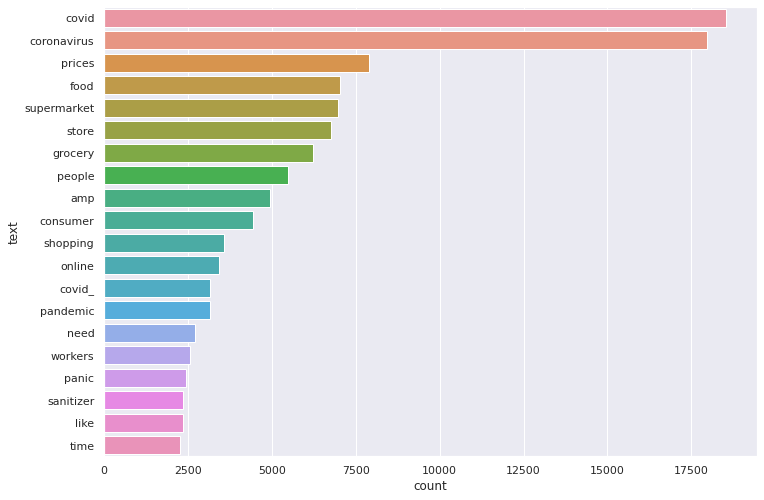

In [35]:
sns.set(font_scale = 1.3)
sns.set(rc={'figure.figsize':(11.7,8.27)})
sns.barplot(data = unigram_df, y = 'text', x = 'count')

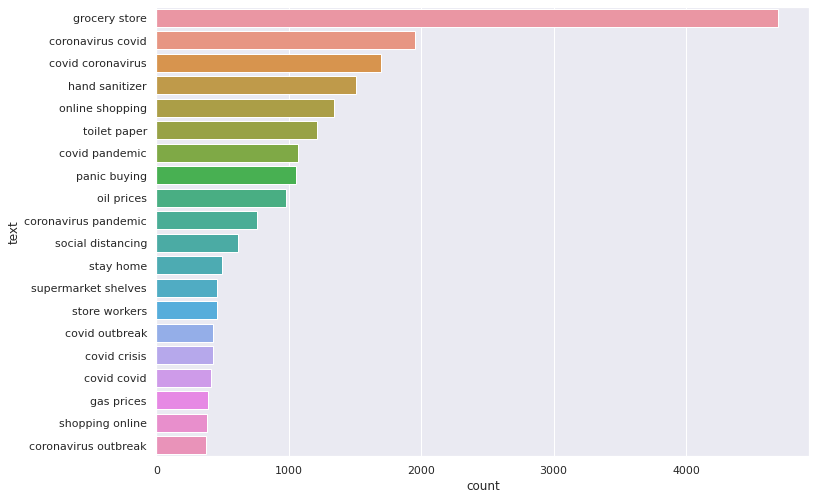

In [36]:
sns.set(font_scale = 1.3)
sns.set(rc={'figure.figsize':(11.7,8.27)})
sns.barplot(data = bigram_df, y = 'text', x = 'count')

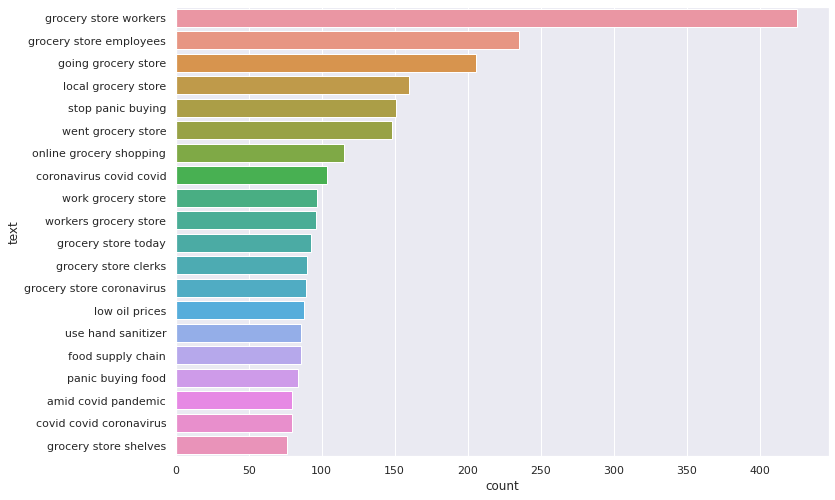

In [37]:
sns.set(font_scale = 1.3)
sns.set(rc={'figure.figsize':(11.7,8.27)})
sns.barplot(data = trigram_df, y = 'text', x = 'count')

## 4) Classification

In [38]:
# Set X and y.
X = df['newTweet']
y = df['label']

# Split data into training and test sets.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [39]:
clf = dict({'SVC': LinearSVC(max_iter = 5000),
            'Logisitc': LogisticRegression(max_iter = 5000),
            'NaiveBayes': MultinomialNB(),
            'RandomForest': RandomForestClassifier(),
           })

In [42]:
def make_models(clf, vectorizer, X_train, y_train, cv = 5):
    
    acc_df = pd.DataFrame(index=range(cv * len(clf)))
    results = []
    for classifier in clf.keys():
        model = Pipeline([('vectorizer',vectorizer),
                   ('clf', clf[classifier])])
        model.fit(X_train, y_train)
        #features = vectorizer.fit_transform(X_train)
        #model = clf[classifier].fit(features, y_train)
        scores = cross_val_score(model, X_train , y_train, cv = cv)
        model_name = classifier
        for fold, score in enumerate(scores):
            results.append((model_name, fold, score))
    
    acc_df = pd.DataFrame(results, columns=['model_name', 'fold', 'accuracy'])
    
    return acc_df

In [43]:
# Number of folds for K-fold cross validation
cv = 10

In [44]:
tfidf_df = make_models(clf, TfidfVectorizer(), X_train, y_train, cv)
count_df = make_models(clf, CountVectorizer(), X_train, y_train, cv)
tfidf_df['vectorizer'] = 'tfidf'
count_df['vectorizer'] = 'count'
combined_df = tfidf_df.append(count_df)
combined_df['method'] = 'none'
combined_df.head(10)

KeyboardInterrupt: ignored

In [ ]:
# Set X and y.
X = df['stemTweet']
y = df['label']

# Split data into training and test sets.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

stem_tfidf_df = make_models(clf, TfidfVectorizer(), X_train, y_train, cv)
stem_count_df = make_models(clf, CountVectorizer(), X_train, y_train, cv)

stem_tfidf_df['method'] = 'stem'
stem_tfidf_df['vectorizer'] = 'tfidf'
stem_count_df['method'] = 'stem'
stem_count_df['vectorizer'] = 'count'
stem_df = stem_tfidf_df.append(stem_count_df)

In [ ]:
# Set X and y.
X = df['lemmaTweet']
y = df['label']

# Split data into training and test sets.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

lemma_tfidf_df = make_models(clf, TfidfVectorizer(), X_train, y_train, cv)
lemma_count_df = make_models(clf, CountVectorizer(), X_train, y_train, cv)

lemma_tfidf_df['vectorizer'] = 'tfidf'
lemma_tfidf_df['method'] = 'lemma'
lemma_count_df['vectorizer'] = 'count'
lemma_count_df['method'] = 'lemma'
lemma_df = lemma_tfidf_df.append(lemma_count_df)

In [ ]:
all_df = lemma_df.append(stem_df)
all_df = all_df.append(combined_df)
all_df.to_csv('pipe_results.csv')

In [ ]:
#sns.set(font_scale = 1.6)
#g = sns.FacetGrid(all_df, col = 'method', row = 'vectorizer', height = 7)
#g.map_dataframe(sns.boxplot, x = 'model_name', y = 'accuracy', palette = 'rainbow')

In [ ]:
#sns.set(font_scale = 1.0)
#g = sns.FacetGrid(data = all_df, col = 'vectorizer', height = 7)
#g.map_dataframe(sns.boxplot, x = 'model_name', y = 'accuracy', hue = 'method'),

In [ ]:
sns.set(font_scale = 1.4)
sns.catplot(x = 'model_name', y = 'accuracy', hue = 'method', height = 7,
            data = all_df, kind = 'box', col = 'vectorizer', palette = 'rainbow')

### Naive Bayes and RandomForest do much worse than Logistic and SVC, and make the boxplot fairly hard to look at. Let's drop them for better visuals. 

In [ ]:
no_nb = all_df[all_df['model_name'] != 'NaiveBayes']
no_nb_rf = no_nb[no_nb['model_name'] != 'RandomForest']
sns.set(font_scale = 1.4)
sns.catplot(x = 'model_name', y = 'accuracy', hue = 'method', height = 7,
            data = no_nb_rf, kind = 'box', col = 'vectorizer', palette = 'rainbow')

### SVC does better when using tfidf, and Logistic Regression does better when using count. Stemming seems to do worse than lemmatization accuracy wise, although lemmatization has more outliers. The best results tend to come from using neither lemmatization nor stemming on the tweets. 
### SVC using tfidf and Logistic with count have approximately the same median, but the SVC has less variance and a slightly more even distribution. 
### It should be noted that the differences in accuracies between the best performing models are very small, and are probably due to the random splits more than methodology.  Bearing that in mind, I would select the LinearSVC using tfidf and no lemma/stem because it takes MUCH less time to run than the logistic regression, and based on these results, it has slightly less variance. 

In [ ]:
all_df = pd.read_csv('pipe_results.csv')

In [ ]:
accuracies = all_df.groupby(['model_name', 'method', 'vectorizer']).accuracy.mean()
stdDev = all_df.groupby(['model_name', 'method', 'vectorizer']).accuracy.std()
metrics_df = pd.concat([accuracies, stdDev], axis = 1, ignore_index = True)
metrics_df.columns = ['mean_acc', 'mean_std']

In [ ]:
metrics_df.sort_values(by = ['mean_acc','method'], ascending = False).head(10)

## Again, this displays just how small the accuracy differences are between the best models. For the sake of efficiency, an SVC using tfidf vectors is recommended. Let's fit one and explore the results more thorouhgly. 

In [40]:
# Set X and y.
X = df['newTweet']
y = df['label']

# Set vectorizer for feature extraction.
vectorizer = TfidfVectorizer()

# Split data into training and test sets to fit the model.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

# Define model for predictions
model = Pipeline([('vectorizer',vectorizer),
                  ('clf', LinearSVC(max_iter = 5000))])

model.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('vectorizer',
                 TfidfVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.float64'>,
                                 encoding='utf-8', input='content',
                                 lowercase=True, max_df=1.0, max_features=None,
                                 min_df=1, ngram_range=(1, 1), norm='l2',
                                 preprocessor=None, smooth_idf=True,
                                 stop_words=None, strip_accents=None,
                                 sublinear_tf=False,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=None, use_idf=True,
                                 vocabulary=None)),
                ('clf',
                 LinearSVC(C=1.0, class_weight=None, dual=True,
                           fit_intercept=True, intercept_scaling=1,
          

In [41]:
preds = model.predict(X_test)

print('Accuracy:', accuracy_score(y_test, preds))
print('\n')
print(classification_report(y_test, preds))

Accuracy: 0.8091593780369291


              precision    recall  f1-score   support

          -1       0.83      0.81      0.82      3158
           0       0.71      0.66      0.68      1489
           1       0.83      0.87      0.85      3585

    accuracy                           0.81      8232
   macro avg       0.79      0.78      0.78      8232
weighted avg       0.81      0.81      0.81      8232



### ~81% accuracy on the training data, not too bad. Precision and recall are significantly lower for neutral tweets than positive or negative, possibly due to the lower support, but it could also be that neutral tweets are harder to classify. This model appears to be slightly better at predicting positive tweets than negative tweets. 

In [42]:
# Set X and y.
X2 = test_df['newTweet']
y2 = test_df['label']


preds = model.predict(X2)
print('Accuracy:', accuracy_score(y2, preds))
print('\n')
print(classification_report(y2, preds))

Accuracy: 0.7880463401790416


              precision    recall  f1-score   support

          -1       0.80      0.80      0.80      1633
           0       0.70      0.61      0.65       619
           1       0.80      0.85      0.82      1546

    accuracy                           0.79      3798
   macro avg       0.77      0.75      0.76      3798
weighted avg       0.79      0.79      0.79      3798



### Model does a little bit worse on test data than on training data. Let's see if we can improve the accuracy by tuning some parameters

In [43]:
# List of parameters that can be tuned
model.get_params()

{'clf': LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
           intercept_scaling=1, loss='squared_hinge', max_iter=5000,
           multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
           verbose=0),
 'clf__C': 1.0,
 'clf__class_weight': None,
 'clf__dual': True,
 'clf__fit_intercept': True,
 'clf__intercept_scaling': 1,
 'clf__loss': 'squared_hinge',
 'clf__max_iter': 5000,
 'clf__multi_class': 'ovr',
 'clf__penalty': 'l2',
 'clf__random_state': None,
 'clf__tol': 0.0001,
 'clf__verbose': 0,
 'memory': None,
 'steps': [('vectorizer',
   TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
                   dtype=<class 'numpy.float64'>, encoding='utf-8',
                   input='content', lowercase=True, max_df=1.0, max_features=None,
                   min_df=1, ngram_range=(1, 1), norm='l2', preprocessor=None,
                   smooth_idf=True, stop_words=None, strip_accents=None,
                   sublinear_tf=False, to

In [44]:
# GridSearchCV goes through specified parameter values and finds the best ones. 
from sklearn.model_selection import GridSearchCV

# We'll try a few different options here.
hyperparameters = { 'vectorizer__max_df': [1, 0.9, 0.95, .85],
                    'vectorizer__ngram_range': [(1,1), (1,2), (2,2),(2,3)],
                  }
model_tune = GridSearchCV(model, hyperparameters, cv=5)

# Fit and tune model
model_tune.fit(X_train, y_train)

GridSearchCV(cv=5, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('vectorizer',
                                        TfidfVectorizer(analyzer='word',
                                                        binary=False,
                                                        decode_error='strict',
                                                        dtype=<class 'numpy.float64'>,
                                                        encoding='utf-8',
                                                        input='content',
                                                        lowercase=True,
                                                        max_df=1.0,
                                                        max_features=None,
                                                        min_df=1,
                                                        ngram_range=(1, 1),
                                                    

In [45]:
# These are the best parameters according to the GridSearch
model_tune.best_params_

{'vectorizer__max_df': 0.9, 'vectorizer__ngram_range': (1, 1)}

In [46]:
# Gridsearch will refit the model on the best settings
model_tune.refit

True

In [47]:
preds = model_tune.predict(X2)
print('Accuracy:', accuracy_score(y2, preds))
print('\n')
print(classification_report(y2, preds))

Accuracy: 0.7880463401790416


              precision    recall  f1-score   support

          -1       0.80      0.80      0.80      1633
           0       0.70      0.61      0.65       619
           1       0.80      0.85      0.82      1546

    accuracy                           0.79      3798
   macro avg       0.77      0.75      0.76      3798
weighted avg       0.79      0.79      0.79      3798



### Looks like our tuning didn't change anything at all. BERT next

# explore which countries have the mislabels

In [ ]:
y_test == preds

In [ ]:
df['newTweet'][6163]

In [ ]:
df['OriginalTweet'][6163]

In [ ]:
df['label'][6163]

In [ ]:
preds[6163]

In [ ]:
df.iloc[6163]

In [ ]:
#this chart works but seaborn actually looks better, and has consistent y labelling across grid.

#worthwhile learning though!

#fig = make_subplots(rows = 3, cols = 1, subplot_titles = ('None', 'Stem', 'Lemma'),)

#fig.add_trace(go.Box(x = count_df['model_name'], y = count_df['accuracy'], name = 'count'), row = 1, col = 1)
#fig.add_trace(go.Box(x = tfidf_df['model_name'], y = tfidf_df['accuracy'], name = 'tfidf'), row = 1, col = 1)
#fig.add_trace(go.Box(x = stem_tfidf_df['model_name'], y = stem_tfidf_df['accuracy'], name = 'tfidf_stem'), row = 2, col = 1)
#fig.add_trace(go.Box(x = stem_count_df['model_name'], y = stem_count_df['accuracy'], name = 'count_stem'), row = 2, col = 1)
#fig.add_trace(go.Box(x = lemma_tfidf_df['model_name'], y = lemma_tfidf_df['accuracy'], name = 'tfidf_lemma'), row = 3, col = 1)
#fig.add_trace(go.Box(x = lemma_count_df['model_name'], y = lemma_count_df['accuracy'], name = 'count_lemma'), row = 3, col = 1)
#fig.update_traces(boxpoints='all', jitter=0)
#fig.show()

import pytorch_lightning as pl
from transformers import BertModel
import torch.nn.functional as F

In [48]:
!pip install transformers

     |████████████████████████████████| 1.1MB 9.2MB/s 
     |████████████████████████████████| 3.0MB 24.5MB/s 
     |████████████████████████████████| 1.1MB 54.1MB/s 
     |████████████████████████████████| 890kB 59.3MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.43-cp36-none-any.whl size=893257 sha256=70b0ec66f7906f937fa6c09fbfd5dd7c7404545cecca2c5112ece2ca5bd22bd0
  Stored in directory: /root/.cache/pip/wheels/29/3c/fd/7ce5c3f0666dab31a50123635e6fb5e19ceb42ce38d4e58f45
Successfully built sacremoses


In [49]:
import torch
from tqdm.notebook import tqdm

from transformers import BertTokenizer

from torch.utils.data import TensorDataset

import transformers
from transformers import BertForSequenceClassification

#import numpy as np
#import pandas as pd
#import re

In [50]:
from sklearn.preprocessing import LabelEncoder

encoder = LabelEncoder()
df['encoded_sentiment'] = encoder.fit_transform(df['label'])

In [51]:
# Set X and y.
X = df['newTweet']
y = df['encoded_sentiment']

# Split data into training and test sets.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [52]:
tokenizer = transformers.BertTokenizer.from_pretrained('bert-base-uncased',do_lower_case=True)

In [53]:
encoded_data_train = tokenizer.batch_encode_plus(
    X_train, 
    truncation = True,
    add_special_tokens=True, 
    return_attention_mask=True, 
    pad_to_max_length=True, 
    max_length=50, 
    return_tensors='pt'
)

encoded_data_test = tokenizer.batch_encode_plus(
    X_test, 
    truncation = True,
    add_special_tokens=True, 
    return_attention_mask=True, 
    pad_to_max_length=True, 
    max_length=50, 
    return_tensors='pt'
)

/usr/local/lib/python3.6/dist-packages/transformers/tokenization_utils_base.py:1773: FutureWarning:

The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).



In [54]:
input_ids_train = encoded_data_train['input_ids']
attention_masks_train = encoded_data_train['attention_mask']
labels_train = torch.tensor(y_train.values)

input_ids_test = encoded_data_test['input_ids']
attention_masks_test = encoded_data_test['attention_mask']
labels_test = torch.tensor(y_test.values)

# Pytorch TensorDataset Instance
dataset_train = TensorDataset(input_ids_train, attention_masks_train, labels_train)
dataset_test = TensorDataset(input_ids_test, attention_masks_test, labels_test)

In [55]:
# initializing the model

model = transformers.BertForSequenceClassification.from_pretrained("bert-base-uncased",
                                                      num_labels=3,
                                                      output_attentions=False,
                                                      output_hidden_states=False)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

In [56]:
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler

dataloader_train = DataLoader(dataset_train, 
                              sampler=RandomSampler(dataset_train), 
                              batch_size=128)

dataloader_test = DataLoader(dataset_test, 
                                   sampler=SequentialSampler(dataset_test), 
                                   batch_size=128)

In [57]:
from transformers import AdamW, get_linear_schedule_with_warmup

optimizer = AdamW(model.parameters(),
                  lr=1e-5, 
                  eps=1e-8)
                  
epochs = 5

scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps=0,
                                            num_training_steps=len(dataloader_train)*epochs)


In [64]:
from sklearn.metrics import f1_score

def f1_score_func(preds, labels):
    preds_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return f1_score(labels_flat, preds_flat, average='weighted')

In [60]:
import random

seed_val = 17
random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)
device = torch.device('cuda')

In [61]:
model.to(device)

for epoch in tqdm(range(1, epochs+1)):
    
    model.train()
    
    loss_train_total = 0

    progress_bar = tqdm(dataloader_train, desc='Epoch {:1d}'.format(epoch), leave=False, disable=False)
    for batch in progress_bar:

        model.zero_grad()
        
        batch = tuple(b.to(device) for b in batch)
        
        inputs = {'input_ids':      batch[0].to(device),
                  'attention_mask': batch[1].to(device),
                  'labels':         batch[2].to(device),
                 }       

        outputs = model(**inputs)
        
        loss = outputs[0]
        loss_train_total += loss.item()
        loss.backward()

        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        optimizer.step()
        scheduler.step()
        
        progress_bar.set_postfix({'training_loss': '{:.3f}'.format(loss.item()/len(batch))})
        
    tqdm.write(f'\nEpoch {epoch}')
    
    loss_train_avg = loss_train_total/len(dataloader_train)            
    tqdm.write(f'Training loss: {loss_train_avg}')



Epoch 1
Training loss: 0.7485301919685777



Epoch 2
Training loss: 0.5066879202229108



Epoch 3
Training loss: 0.42522676381491875



Epoch 4
Training loss: 0.3848018053081609



Epoch 5
Training loss: 0.3620072840604671



In [62]:
def evaluate(dataloader_test):

    model.eval()
    
    loss_val_total = 0
    predictions, true_vals = [], []
    
    for batch in dataloader_val:
        
        batch = tuple(b.to(device) for b in batch)
        
        inputs = {'input_ids':      batch[0],
                  'attention_mask': batch[1],
                  'labels':         batch[2],
                 }

        with torch.no_grad():        
            outputs = model(**inputs)
            
        loss = outputs[0]
        logits = outputs[1]
        loss_val_total += loss.item()

        logits = logits.detach().cpu().numpy()
        label_ids = inputs['labels'].cpu().numpy()
        predictions.append(logits)
        true_vals.append(label_ids)
    
    loss_val_avg = loss_val_total/len(dataloader_val) 
    
    predictions = np.concatenate(predictions, axis=0)
    true_vals = np.concatenate(true_vals, axis=0)
            
    return loss_val_avg, predictions, true_vals

In [65]:
val_loss, predictions, true_vals = evaluate(dataloader_test)
val_f1 = f1_score_func(predictions, true_vals)

In [66]:
print('Val Loss = ', val_loss)
print('Val F1 = ', val_f1)

Val Loss =  0.42918163262880765
Val F1 =  0.8546098185580956


In [67]:
encoded_classes = encoder.classes_
predicted_category = [encoded_classes[np.argmax(x)] for x in predictions]
true_category = [encoded_classes[x] for x in true_vals]

In [68]:
x = 0
for i in range(len(true_category)):
    if true_category[i] == predicted_category[i]:
        x += 1
        
print('Accuracy Score = ', x / len(true_category))

Accuracy Score =  0.8551992225461613


In [69]:
from sklearn.metrics import confusion_matrix
confusion_mat = confusion_matrix(y_true = true_category, y_pred = predicted_category, labels=list(encoded_classes))

In [77]:
print(classification_report(true_category, predicted_category))

              precision    recall  f1-score   support

          -1       0.83      0.87      0.85      1633
           0       0.81      0.75      0.78       619
           1       0.86      0.84      0.85      1546

    accuracy                           0.84      3798
   macro avg       0.83      0.82      0.82      3798
weighted avg       0.84      0.84      0.84      3798



## Use the test dataset to evaluate model

In [74]:
test_df['encoded_sentiment'] = encoder.fit_transform(test_df['label'])

# Set X and y.
X = test_df['newTweet']
y = test_df['encoded_sentiment']

encoded_data_test = tokenizer.batch_encode_plus(
    X, 
    truncation = True,
    add_special_tokens=True, 
    return_attention_mask=True, 
    pad_to_max_length=True, 
    max_length=50, 
    return_tensors='pt'
)

input_ids_test = encoded_data_test['input_ids']
attention_masks_test = encoded_data_test['attention_mask']
labels_test = torch.tensor(y.values)

# Pytorch TensorDataset Instance
dataset_test = TensorDataset(input_ids_test, attention_masks_test, labels_test)

dataloader_test = DataLoader(dataset_test, 
                                   sampler=SequentialSampler(dataset_test), 
                                   batch_size=128)

/usr/local/lib/python3.6/dist-packages/transformers/tokenization_utils_base.py:1773: FutureWarning:

The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).



In [75]:
val_loss, predictions, true_vals = evaluate(dataloader_test)
val_f1 = f1_score_func(predictions, true_vals)

In [79]:
encoded_classes = encoder.classes_
predicted_category = [encoded_classes[np.argmax(x)] for x in predictions]
true_category = [encoded_classes[x] for x in true_vals]

x = 0
for i in range(len(true_category)):
    if true_category[i] == predicted_category[i]:
        x += 1
        
print('Accuracy Score = ', x / len(true_category))
print('\n')
print(classification_report(true_category, predicted_category))

Accuracy Score =  0.8378093733543971


              precision    recall  f1-score   support

          -1       0.83      0.87      0.85      1633
           0       0.81      0.75      0.78       619
           1       0.86      0.84      0.85      1546

    accuracy                           0.84      3798
   macro avg       0.83      0.82      0.82      3798
weighted avg       0.84      0.84      0.84      3798

